## CreditRisk+ 모델

In [ ]:
# # 3. 푸아송 기반 부도 시뮬레이션
# for i in range(n_simulations):
#     defaulted = np.random.binomial(1, pd_probs)  # 부도 여부 (0 또는 1)
#     total_loss = np.sum(defaulted * exposures * lgd)
#     losses[i] = total_loss


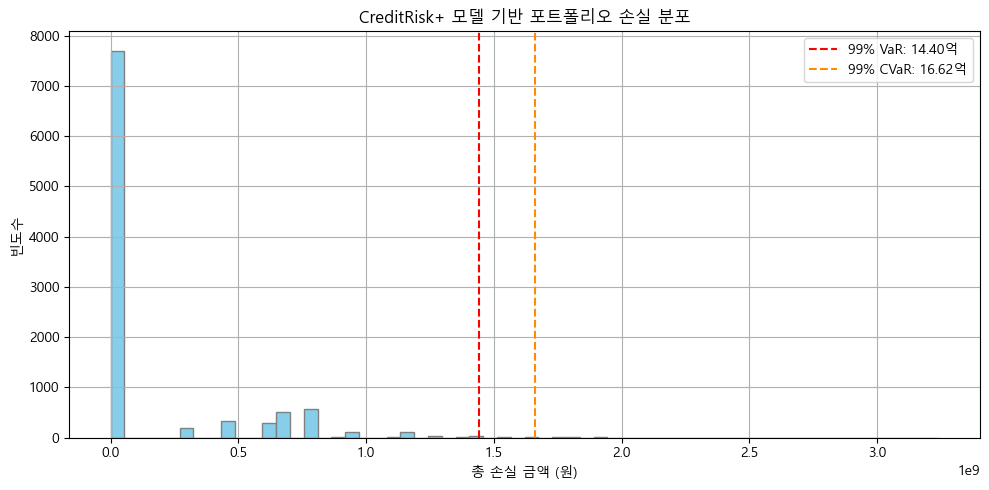

{'포트폴리오 기대손실': 166602000, '99% VaR': 1440000000, '99% CVaR': 1662178218}

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CreditRisk+ 가정: 독립된 기업들에 대해 확률적 부도 이벤트 시뮬레이션

# 1. 포트폴리오 설정 (10개 기업)
n_firms = 10
exposures = np.random.randint(5, 20, size=n_firms) * 1e8  # 50억 ~ 200억
pd_probs = np.random.uniform(0.005, 0.05, size=n_firms)  # 부도확률 0.5%~5%
lgd = 0.6  # 손실율 60%

# 2. 시뮬레이션 설정
n_simulations = 10000
losses = np.zeros(n_simulations)

# 3. 푸아송 기반 부도 시뮬레이션
for i in range(n_simulations):
    defaulted = np.random.binomial(1, pd_probs)  # 부도 여부 (0 또는 1)
    total_loss = np.sum(defaulted * exposures * lgd)
    losses[i] = total_loss

# 4. 결과 분석
var_99 = np.percentile(losses, 99)
cvar_99 = losses[losses >= var_99].mean()

# 5. 손실분포 시각화
plt.figure(figsize=(10, 5))
plt.hist(losses, bins=60, color='skyblue', edgecolor='gray')
plt.axvline(var_99, color='red', linestyle='--', label=f"99% VaR: {var_99/1e8:.2f}억")
plt.axvline(cvar_99, color='darkorange', linestyle='--', label=f"99% CVaR: {cvar_99/1e8:.2f}억")
plt.title("CreditRisk+ 모델 기반 포트폴리오 손실 분포")
plt.xlabel("총 손실 금액 (원)")
plt.ylabel("빈도수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 핵심 결과 요약
summary = {
    "포트폴리오 기대손실": round(np.mean(losses)),
    "99% VaR": round(var_99),
    "99% CVaR": round(cvar_99)
}

summary


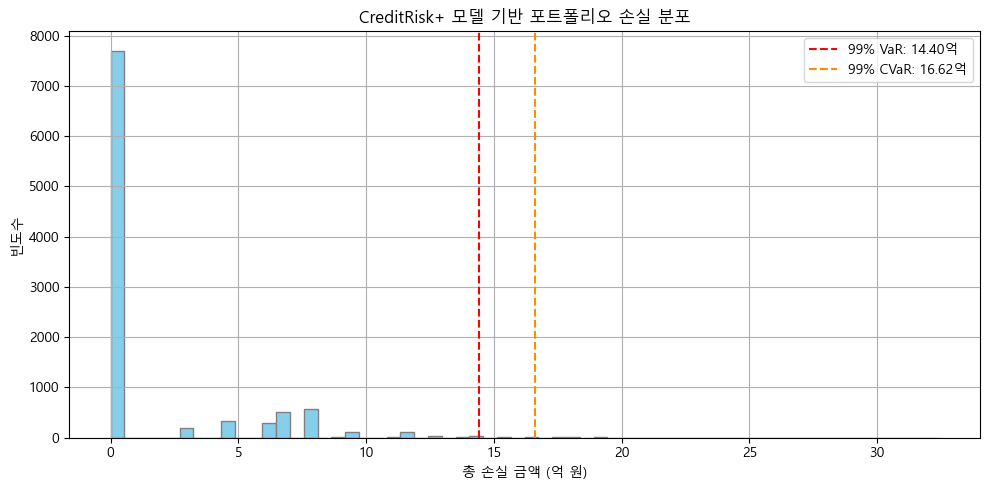

In [8]:
# 그래프의 X축 단위를 억 원으로 변환하여 시각화
plt.figure(figsize=(10, 5))
plt.hist(losses / 1e8, bins=60, color='skyblue', edgecolor='gray')
plt.axvline(var_99 / 1e8, color='red', linestyle='--', label=f"99% VaR: {var_99/1e8:.2f}억")
plt.axvline(cvar_99 / 1e8, color='darkorange', linestyle='--', label=f"99% CVaR: {cvar_99/1e8:.2f}억")
plt.title("CreditRisk+ 모델 기반 포트폴리오 손실 분포")
plt.xlabel("총 손실 금액 (억 원)")
plt.ylabel("빈도수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## CreditMetrics 시뮬레이션 기반

In [2]:
# 세션 리셋으로 인한 재로드
import numpy as np
import pandas as pd

# 신용등급
ratings = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "D"]
num_ratings = len(ratings)

# 이동확률 행렬 (예시)
transition_matrix = np.array([
    [0.90, 0.08, 0.01, 0.00, 0.00, 0.00, 0.00, 0.01],
    [0.01, 0.89, 0.07, 0.01, 0.00, 0.00, 0.00, 0.02],
    [0.00, 0.02, 0.88, 0.06, 0.01, 0.01, 0.00, 0.02],
    [0.00, 0.00, 0.05, 0.85, 0.05, 0.02, 0.01, 0.02],
    [0.00, 0.00, 0.00, 0.06, 0.80, 0.06, 0.04, 0.04],
    [0.00, 0.00, 0.00, 0.00, 0.08, 0.75, 0.10, 0.07],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.10, 0.70, 0.20],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00]
])

# 할인율
discount_rates = {
    "AAA": 0.02,
    "AA": 0.025,
    "A": 0.03,
    "BBB": 0.035,
    "BB": 0.05,
    "B": 0.07,
    "CCC": 0.12,
    "D": 1.00
}

# 초기 채권 정보
initial_rating = "BBB"
par_value = 100
initial_price = par_value / (1 + discount_rates[initial_rating])
n_simulations = 10000

# 시뮬레이션 수행
initial_idx = ratings.index(initial_rating)
simulated_ratings_idx = np.random.choice(
    np.arange(num_ratings),
    size=n_simulations,
    p=transition_matrix[initial_idx]
)

# 시가 계산
final_prices = np.array([
    0 if ratings[i] == "D" else par_value / (1 + discount_rates[ratings[i]])
    for i in simulated_ratings_idx
])

losses = initial_price - final_prices
var_99 = np.percentile(losses, 99)
cvar_99 = losses[losses >= var_99].mean()

summary = {
    "초기 등급": initial_rating,
    "초기 시가": round(initial_price, 2),
    "평균 손실": round(np.mean(losses), 2),
    "99% VaR": round(var_99, 2),
    "99% CVaR": round(cvar_99, 2)
}

sample_losses = pd.DataFrame({
    "등급결과": [ratings[i] for i in simulated_ratings_idx[:10]],
    "최종시가": final_prices[:10],
    "손실금액": losses[:10].round(2)
})

import ace_tools as tools; tools.display_dataframe_to_user(name="CreditMetrics 시뮬레이션 결과 샘플", dataframe=sample_losses)
summary


ModuleNotFoundError: No module named 'ace_tools'

In [3]:
# 사용자에게 sample_losses 결과 직접 출력
sample_losses


,등급결과,최종시가,손실금액
0,BBB,96.618357,0.00
1,BBB,96.618357,0.00
2,D,0.000000,96.62
3,BBB,96.618357,0.00
4,BBB,96.618357,0.00
5,BBB,96.618357,0.00
6,BBB,96.618357,0.00
7,BBB,96.618357,0.00
8,BBB,96.618357,0.00
9,BBB,96.618357,0.00


In [4]:
import numpy as np
import pandas as pd

# 신용등급 및 개수
ratings = ["AAA", "AA", "A", "BBB", "BB", "B", "CCC", "D"]
num_ratings = len(ratings)

# 등급별 이동 확률 행렬 (Transition Matrix)
transition_matrix = np.array([
    [0.90, 0.08, 0.01, 0.00, 0.00, 0.00, 0.00, 0.01],
    [0.01, 0.89, 0.07, 0.01, 0.00, 0.00, 0.00, 0.02],
    [0.00, 0.02, 0.88, 0.06, 0.01, 0.01, 0.00, 0.02],
    [0.00, 0.00, 0.05, 0.85, 0.05, 0.02, 0.01, 0.02],
    [0.00, 0.00, 0.00, 0.06, 0.80, 0.06, 0.04, 0.04],
    [0.00, 0.00, 0.00, 0.00, 0.08, 0.75, 0.10, 0.07],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.10, 0.70, 0.20],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00]
])

# 등급별 할인율
discount_rates = {
    "AAA": 0.02,
    "AA": 0.025,
    "A": 0.03,
    "BBB": 0.035,
    "BB": 0.05,
    "B": 0.07,
    "CCC": 0.12,
    "D": 1.00
}

# 초기 등급, 액면가, 시가
initial_rating = "BBB"
par_value = 100
initial_price = par_value / (1 + discount_rates[initial_rating])

# 시뮬레이션 수
n_simulations = 10000
initial_idx = ratings.index(initial_rating)

# 신용등급 시뮬레이션
simulated_ratings_idx = np.random.choice(
    np.arange(num_ratings),
    size=n_simulations,
    p=transition_matrix[initial_idx]
)

# 최종 시가 계산
final_prices = np.array([
    0 if ratings[i] == "D" else par_value / (1 + discount_rates[ratings[i]])
    for i in simulated_ratings_idx
])

# 손실 계산
losses = initial_price - final_prices

# VaR 및 CVaR 계산
var_99 = np.percentile(losses, 99)
cvar_99 = losses[losses >= var_99].mean()

# 결과 요약
summary = {
    "초기 등급": initial_rating,
    "초기 시가": round(initial_price, 2),
    "평균 손실": round(np.mean(losses), 2),
    "99% VaR": round(var_99, 2),
    "99% CVaR": round(cvar_99, 2)
}

# 출력
summary


{'초기 등급': 'BBB',
 '초기 시가': 96.62,
 '평균 손실': 1.94,
 '99% VaR': 96.62,
 '99% CVaR': 96.62}

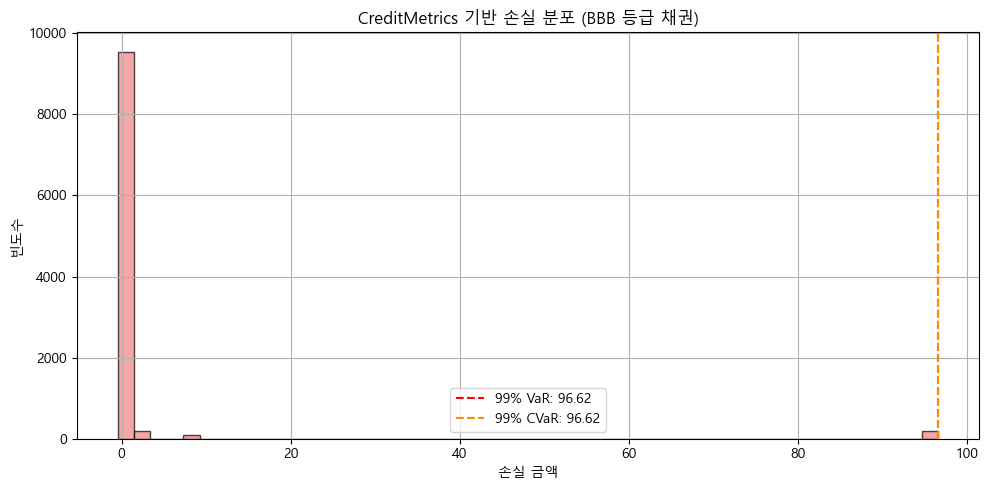

In [6]:
import matplotlib.pyplot as plt

# Windows에서 한글이 잘 보이는 기본 폰트 설정 (예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 깨짐 방지

# 시각화: 전체 손실 분포
plt.figure(figsize=(10, 5))
plt.hist(losses, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(var_99, color='red', linestyle='--', label=f"99% VaR: {var_99:.2f}")
plt.axvline(cvar_99, color='darkorange', linestyle='--', label=f"99% CVaR: {cvar_99:.2f}")
plt.title("CreditMetrics 기반 손실 분포 (BBB 등급 채권)")
plt.xlabel("손실 금액")
plt.ylabel("빈도수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
